In [1]:
import matplotlib
matplotlib.use('Agg')

import numpy as np
import collections
from functools import partial
from os.path import expanduser
from tqdm import tqdm
import h5py

from surround.image_processing import *
from surround.data_handling import *
from surround.efficient_coding import *
from aesthetics.plotting import *
from surround.modeling import gaussian, difference_of_gaussians

import pyret.filtertools as ft
from sklearn.decomposition import PCA
from scipy.stats import sem
from scipy.optimize import curve_fit, minimize
from scipy.interpolate import interp1d
from scipy.stats import pearsonr

from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.signal import convolve2d
from scipy.misc import imresize

# import tensorflow as tf

# This is a bit of magic to make matplotlib figures appear inline in the
# notebook rather than in a new window.
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, FormatStrFormatter

# plt.style.use('deepretina')

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

/home/lane/.local/lib/python3.6/site-packages/matplotlib/style/core.py:197: UserWarning: In /home/lane/.config/matplotlib/stylelib/deepretina2.mplstyle: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  warnings.warn(message)
/home/lane/.local/lib/python3.6/site-packages/matplotlib/style/core.py:197: UserWarning: In /home/lane/.config/matplotlib/stylelib/deepretina2.mplstyle: axes.hold is deprecated, will be removed in 3.0
  warnings.warn(message)


In [2]:
constants = np.load(os.path.expanduser('~/data/surround/2017_10_9_diversity_constants.npy')).item()
both_results = np.load(os.path.expanduser('~/data/surround/2017_10_20_diversity_both_results.npy')).item()

In [3]:
constants.keys()

dict_keys(['microns_per_degree', 'pixelsToDeg', 'photoreceptor_width', 'retina_width', 'frequency_spacing', 'highest_frequency', 'receptive_fields', 'N', 'freqs', 'space', 'spacing', 'contrast', 'center_widths', 'surround_widths', 'center_strengths', 'surround_strengths', 'fit_failures', 'median_center_widths', 'horz_pf', 'ama_pf', 'target_power', 'resolution', 'info_maps', 'failures', 'detailed_failures', 'celltype', 'center', 'input_noise', 'output_noise', 'target_snr'])

In [4]:
both_results.keys()

dict_keys([100.0])

In [5]:
both_results[100.0]['random'].keys()

dict_keys(['mean_errors', 'sem_errors', 'results', 'errors', 'channels'])

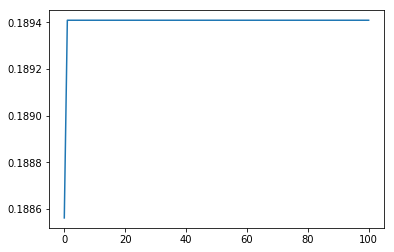

In [6]:
plt.plot(np.stack(both_results[100.0]['random']['results'][0]['hw']))

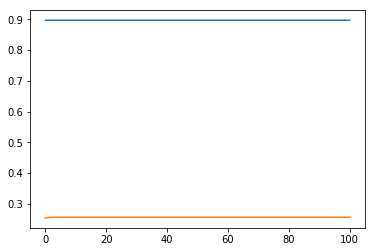

In [7]:
plt.plot(np.stack(both_results[100.0]['random']['results'][1]['hw']))

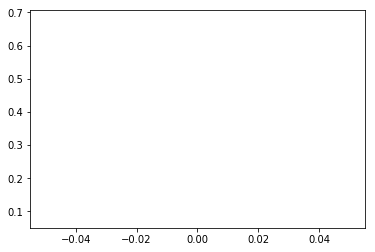

In [8]:
plt.plot(np.stack(both_results[100.0]['random']['results'][2]['hw']))

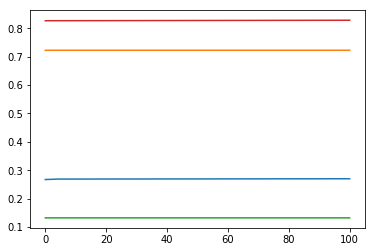

In [9]:
plt.plot(np.stack(both_results[100.0]['random']['results'][3]['hw']))

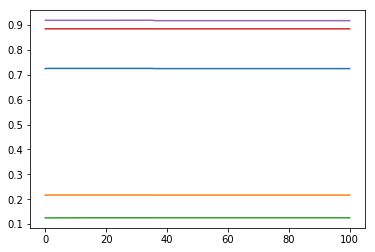

In [10]:
plt.plot(np.stack(both_results[100.0]['random']['results'][4]['hw']))

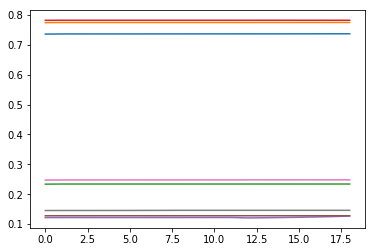

In [11]:
plt.plot(np.stack(both_results[100.0]['random']['results'][-3]['hw']))

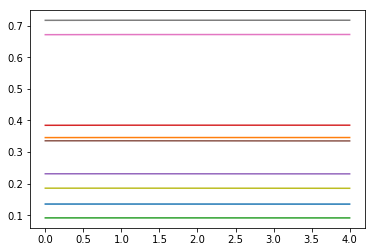

In [12]:
plt.plot(np.stack(both_results[100.0]['random']['results'][-2]['hw']))

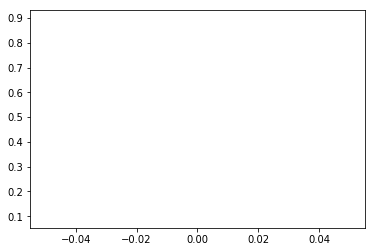

In [13]:
plt.plot(np.stack(both_results[100.0]['random']['results'][-1]['hw']))

In [14]:
len(both_results[100.0]['random']['results'])

10

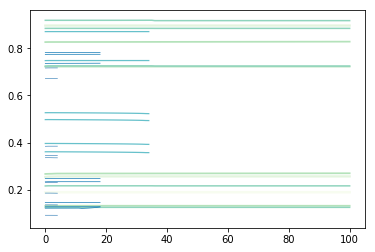

In [15]:
colors = plt.cm.GnBu(np.linspace(0, 1, 10))
for i in range(10):
    plt.plot(np.stack(both_results[100.0]['random']['results'][i]['hw']), color=colors[i],
             linewidth=(10.0 - i)/4.)

In [16]:
np.stack(both_results[100.0]['random']['results'][i]['hw']).shape

(101, 10)

In [17]:
final_resting_places = [np.stack(both_results[100.0]['random']['results'][i]['hw'])[-1] for i in range(10)]

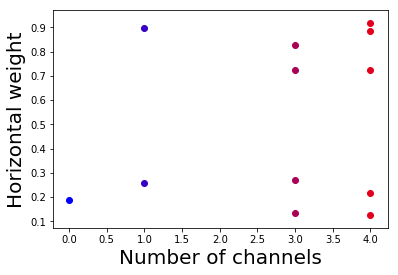

In [18]:
colors = plt.cm.brg(np.linspace(0, 1, 10))
for i in range(10):
    these_dots = final_resting_places[i]
    plt.scatter(len(these_dots) * [i], these_dots, color=colors[i])
plt.xlabel('Number of channels', fontsize=20)
plt.ylabel('Horizontal weight', fontsize=20)

In [35]:
both_results[100.0]['random']['results'][i].keys()

dict_keys(['input', 'labels', 'output', 'kernel', 'hw', 'cw', 'decoder', 'snr', 'snr_reg', 'input_noise', 'output_noise'])

In [36]:
[np.stack(both_results[100.0]['random']['results'][i]['cw'])[-1] for i in range(10)]

[array([ 0.99858803], dtype=float32),
 array([ 0.99988735,  0.99216664], dtype=float32),
 array([ 0.99892384,  0.99783343,  0.99997759], dtype=float32),
 array([ 0.9999758 ,  0.9999882 ,  0.99904662,  0.9999038 ], dtype=float32),
 array([ 0.99997425,  0.99989021,  0.99994409,  0.99813926,  0.99995589], dtype=float32),
 array([ 0.99998927,  0.99991012,  0.99991286,  0.99999142,  0.99994469,
         0.99744606], dtype=float32),
 array([ 0.99996388,  0.99626619,  0.99995077,  0.99703288,  0.99996269,
         0.99965298,  0.9999398 ], dtype=float32),
 array([ 0.99975473,  0.99999475,  0.99818355,  0.99996936,  0.99998379,
         0.99998689,  0.99991465,  0.99997318], dtype=float32),
 array([ 0.99997449,  0.99997187,  0.99981636,  0.99953687,  0.99960011,
         0.99993622,  0.99983966,  0.99924278,  0.99983382], dtype=float32),
 array([ 0.99996054,  0.99927264,  0.9994936 ,  0.99987149,  0.99993169,
         0.99977189,  0.99992383,  0.99862099,  0.99985564,  0.99996018], dtype=float

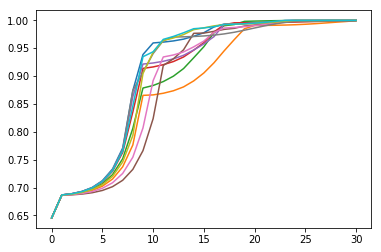

In [38]:
plt.plot(np.stack(both_results[100.0]['random']['results'][-1]['cw']))

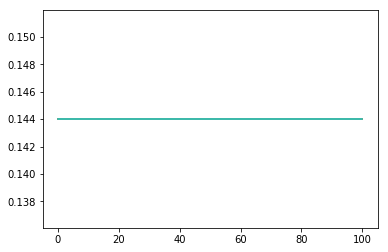

In [10]:
plt.plot(np.stack(both_results['homogenous']['results'][-1]['hw']))

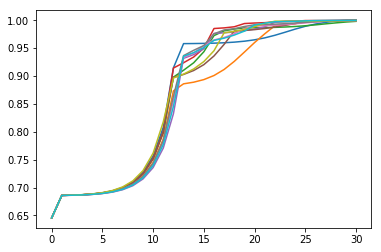

In [39]:
plt.plot(np.stack(both_results[100.0]['homogenous']['results'][-1]['cw']))

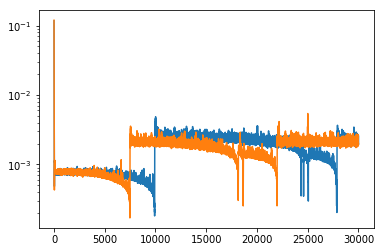

In [40]:
plt.plot(both_results[100.0]['homogenous']['errors'][0])
plt.plot(both_results[100.0]['random']['errors'][0])
plt.yscale('log')

In [12]:
both_results['homogenous']['results'][-1].keys()

dict_keys(['input', 'labels', 'output', 'kernel', 'hw', 'cw', 'decoder', 'snr', 'snr_reg', 'input_noise', 'output_noise'])

In [13]:
both_results['homogenous'].keys()

dict_keys(['mean_errors', 'sem_errors', 'results', 'errors', 'channels'])

In [14]:
len(both_results['homogenous']['errors'][0])

100000

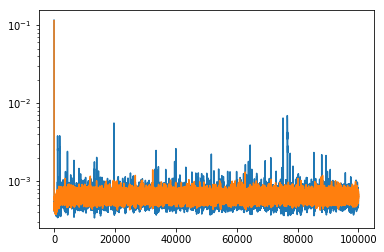

In [15]:
plt.plot(both_results['homogenous']['errors'][0])
plt.plot(both_results['random']['errors'][0])
plt.yscale('log')

In [16]:
np.min(both_results['random']['errors'][0])

0.0003741062

In [19]:
np.min(both_results['homogenous']['errors'][0])

0.00033793654

In [18]:
plt.errorbar(range(1, 10), diverse_means, yerr=diverse_errors, color='k', linewidth=4, label='diverse')
plt.errorbar(range(1, 10), homogenous_means, yerr=homogenous_errors, color='r', linewidth=4, label='single-cell optimal')
plt.errorbar(range(1, 10), mean_errors, yerr=sem_errors, color='g', linewidth=4, label='optimal diverse')
adjust_spines(plt.gca())
plt.xlabel('Number of receptive fields', fontsize=20)
plt.ylabel('Decoding error (MSE)', fontsize=20)
plt.legend(fontsize=14, frameon=False, loc='upper right')

NameError: name 'diverse_means' is not defined

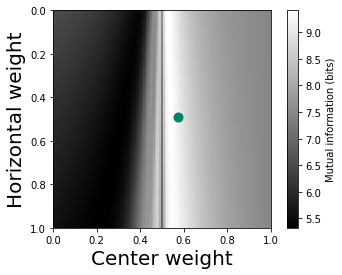

In [349]:
all_hws = results['hw'][-1]
all_cws = results['cw'][-1]

plt.imshow(info_maps[celltype], cmap='gray', extent=(center_weights[0], center_weights[-1], 
                                                     horz_weights[-1], horz_weights[0]))
colors = plt.cm.summer(np.linspace(0,1,max_filters))
for i, cw, hw in zip(range(channel_depth), [max([cw, 0]) for cw in all_cws], all_hws):
    plt.plot(cw, hw, color=colors[i], marker='.', markersize=18)
        
# plt.plot(actual_cws[0], actual_hws[0], color='r', marker='*', markersize=18)
plt.colorbar(label='Mutual information (bits)')
plt.xlabel('Center weight', fontsize=20)
plt.ylabel('Horizontal weight', fontsize=20)

In [353]:
print("'optimal' hw is %s." %results['hw'][-1])
print("'optimal' cw is %s." %results['cw'][-1])

'optimal' hw is [ 0.47837314  0.49567163].
'optimal' cw is [ 0.56802303  0.56579578].


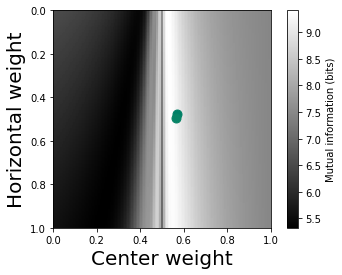

In [354]:
all_hws = results['hw'][-1]
all_cws = results['cw'][-1]

plt.imshow(info_maps[celltype], cmap='gray', extent=(center_weights[0], center_weights[-1], 
                                                     horz_weights[-1], horz_weights[0]))
colors = plt.cm.summer(np.linspace(0,1,max_filters))
for i, cw, hw in zip(range(channel_depth), [max([cw, 0]) for cw in all_cws], all_hws):
    plt.plot(cw, hw, color=colors[i], marker='.', markersize=18)
        
# plt.plot(actual_cws[0], actual_hws[0], color='r', marker='*', markersize=18)
plt.colorbar(label='Mutual information (bits)')
plt.xlabel('Center weight', fontsize=20)
plt.ylabel('Horizontal weight', fontsize=20)

In [360]:
constrained_filter2_results = results

(0, 1)

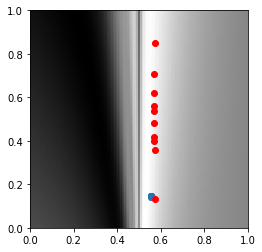

In [93]:
plt.imshow(info_maps[celltype], cmap='gray', extent=(center_weights[0], center_weights[-1], 
                                                     horz_weights[-1], horz_weights[0]))
plt.scatter(homogenous_all_results[-1]['cw'][-1], homogenous_all_results[-1]['hw'][-1])
plt.scatter(all_results[-1]['cw'][-1], all_results[-1]['hw'][-1], color='r')
plt.ylim(0,1)
plt.xlim(0,1)

In [89]:
homogenous_all_results[-1]['cw'][-1]

array([ 0.55430555,  0.5567019 ,  0.55728859,  0.55511463,  0.55650377,
        0.55468947,  0.55686325,  0.55698782,  0.56056893,  0.55832624], dtype=float32)

In [88]:
homogenous_all_results[-1]['hw'][-1]

array([ 0.14514522,  0.14295828,  0.14404492,  0.14419974,  0.14446889,
        0.14494129,  0.14596899,  0.1423844 ,  0.14328572,  0.14601141], dtype=float32)

In [86]:
all_results[-1]['hw'][-1]

array([ 0.84760028,  0.55902576,  0.48140588,  0.53616631,  0.13222286,
        0.61920631,  0.40110084,  0.35921985,  0.70908016,  0.41581616], dtype=float32)

In [77]:
all_results[-1]['cw'][-1]

array([ 0.57269865,  0.57033712,  0.57176095,  0.57120997,  0.57508403,
        0.57056665,  0.57178342,  0.57284617,  0.56822211,  0.5721162 ], dtype=float32)

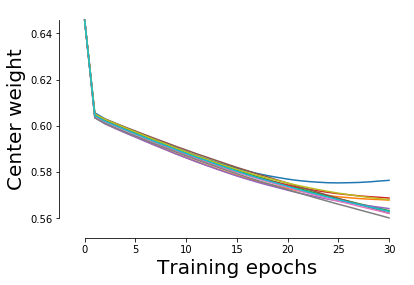

In [456]:
plt.plot(np.stack(all_results[-1]['cw']))
plt.xlabel('Training epochs', fontsize=20)
plt.ylabel('Center weight', fontsize=20)
#plt.plot([np.mean((np.squeeze(results['output'][i]) - results['labels'][i])**2) for i in range(len(results['output']))])
adjust_spines(plt.gca())

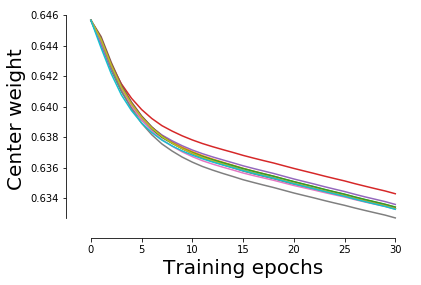

In [447]:
plt.plot(np.stack(all_results[-1]['cw']))
plt.xlabel('Training epochs', fontsize=20)
plt.ylabel('Center weight', fontsize=20)
#plt.plot([np.mean((np.squeeze(results['output'][i]) - results['labels'][i])**2) for i in range(len(results['output']))])
adjust_spines(plt.gca())

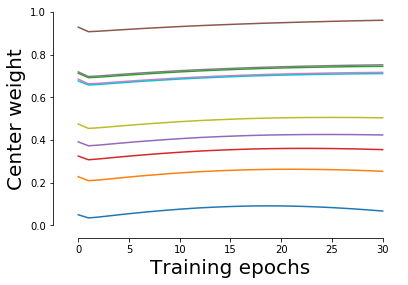

In [458]:
plt.plot(np.stack(all_results[-1]['hw']))
plt.xlabel('Training epochs', fontsize=20)
plt.ylabel('Center weight', fontsize=20)
#plt.plot([np.mean((np.squeeze(results['output'][i]) - results['labels'][i])**2) for i in range(len(results['output']))])
adjust_spines(plt.gca())

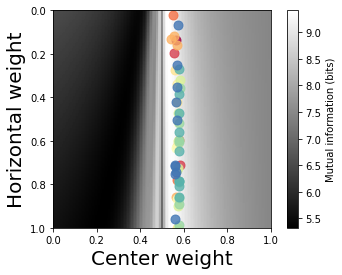

In [459]:
colors = plt.cm.Spectral(np.linspace(0,3,max_filters))
plt.imshow(info_maps[celltype], cmap='gray', extent=(center_weights[0], center_weights[-1], 
                                                     horz_weights[-1], horz_weights[0]))

for channel_id in range(len(all_results)):
    all_hws = np.where(all_results[channel_id]['hw'][-1] > 1, 1, all_results[channel_id]['hw'][-1])
    all_cws = all_results[channel_id]['cw'][-1]

    for i, cw, hw in zip(range(channel_depth), [max([cw, 0]) for cw in all_cws], all_hws):
        plt.plot(cw, hw, color=colors[channel_id], marker='.', markersize=18, alpha=0.8)

# plt.plot(actual_cws[0], actual_hws[0], color='r', marker='*', markersize=18)
plt.colorbar(label='Mutual information (bits)')
plt.xlabel('Center weight', fontsize=20)
plt.ylabel('Horizontal weight', fontsize=20)

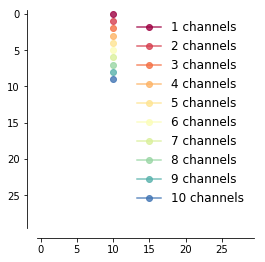

In [469]:
colors = plt.cm.Spectral(np.linspace(0,3,max_filters))
empty_map = np.zeros((max_filters,max_filters))
plt.imshow(empty_map, clim=[0,10], cmap='gray_r')
for channel_id in range(len(all_results)):
    plt.plot(10, channel_id, color=colors[channel_id], marker='.', 
                markersize=12, alpha=0.8, label='%d channels' %(channel_id+1))
plt.legend(frameon=False, fontsize=12)
adjust_spines(plt.gca())

In [474]:
all_results[-1]['labels'][0].shape

(128, 398)

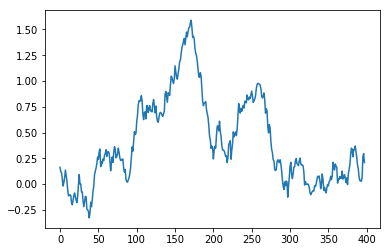

In [475]:
plt.plot(all_results[-1]['labels'][0][0])

In [476]:
all_results[-1].keys()

dict_keys(['input', 'labels', 'output', 'kernel', 'hw', 'cw', 'decoder', 'snr', 'snr_reg', 'input_noise', 'output_noise', 'label'])

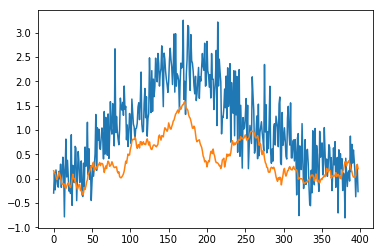

In [478]:
plt.plot(all_results[-1]['output'][0][0])
plt.plot(all_results[-1]['labels'][0][0])

In [479]:
np.mean((all_results[-1]['output'][0][0] - all_results[-1]['labels'][0][0])**2)

1.3443745976734056